# Выбор локации для скважины

Для добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищем месторождения, для каждого определяют значения признаков;
- Строим модель и оцениваем объём запасов;
- Выбираем месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Описание данных

Данные геологоразведки трёх регионов находятся в файлах.


- *id* — уникальный идентификатор скважины;


- *f0*, *f1*, *f2* — три признака точек (неважно, что они означают, но сами признаки значимы);


- *product* — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).


- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.


- Бюджет на разработку скважин в регионе — 10 млрд рублей.


- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.


- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузка и подготовка данных

Подключим нужные библиотеки, прочитаем файлы и посмотрим на их значения, размеры и типы данных.

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle
from scipy import stats as st

from IPython.display import display
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

geo_data_0.info()
display(geo_data_0.head(5))
print()
geo_data_1.info()
display(geo_data_1.head(5))
print()
geo_data_2.info()
display(geo_data_2.head(5))
print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Для удобства переименуем индексы в id скважины.

In [3]:
geo_data_0.index = geo_data_0['id']
geo_data_1.index = geo_data_1['id']
geo_data_2.index = geo_data_2['id']

Проверим датасеты на наличие дубликатов:

In [4]:
print('Число дубликатов в geo_data_0:', geo_data_0.duplicated().sum())
print('Число дубликатов в geo_data_1:', geo_data_1.duplicated().sum())
print('Число дубликатов в geo_data_2:', geo_data_2.duplicated().sum())

Число дубликатов в geo_data_0: 0
Число дубликатов в geo_data_1: 0
Число дубликатов в geo_data_2: 0


Посмотрим на распределения параметров:

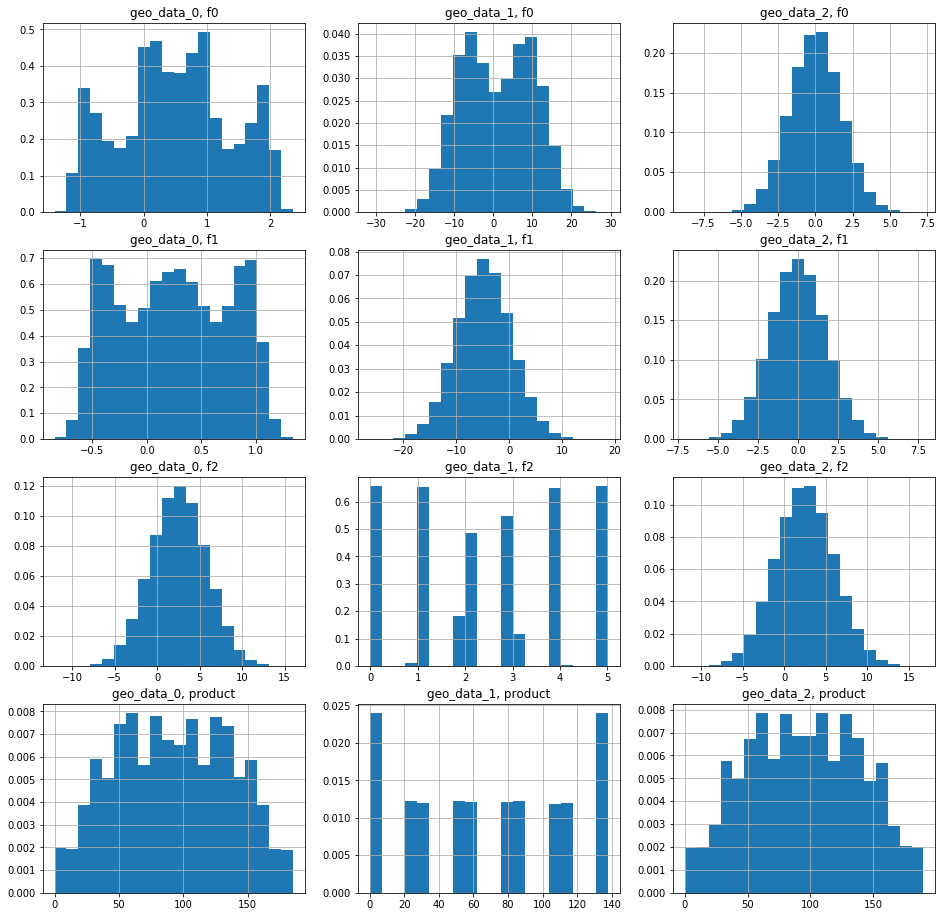

In [5]:
parameters = ['f0', 'f1', 'f2', 'product']
fig, axes = plt.subplots(len(parameters), 3, figsize=(16,16))
for i in range(len(parameters)):
    title_0 = 'geo_data_0, ' + parameters[i]
    title_1 = 'geo_data_1, ' + parameters[i]
    title_2 = 'geo_data_2, ' + parameters[i]
    geo_data_0[parameters[i]].hist(bins=20, density=True,figure=fig, ax=axes[i][0]).set_title(title_0)
    geo_data_1[parameters[i]].hist(bins=20, density=True, figure=fig, ax=axes[i][1]).set_title(title_1)
    geo_data_2[parameters[i]].hist(bins=20, density=True, figure=fig, ax=axes[i][2]).set_title(title_2)

В большинстве распределение нормальное, кроме f0 и f1 для geo_data_0 (есть тяжёлые хвосты), и f2 и product для geo_data_1, распределение которых близко к равномерному и видна сильная корреляционная связь между параметром и целевым признаком. 

Посмотрим коэффициент корреляции f2 и product для geo_data_1 и проверим признаки на мультиколлинеарность.

In [6]:
print('Корреляция f2 и product для geo_data_1:', geo_data_1['f2'].corr(geo_data_1['product']))

Корреляция f2 и product для geo_data_1: 0.9993969704906548


Почти 1. Этот признак окажет значительное влияние на выбор скважины.

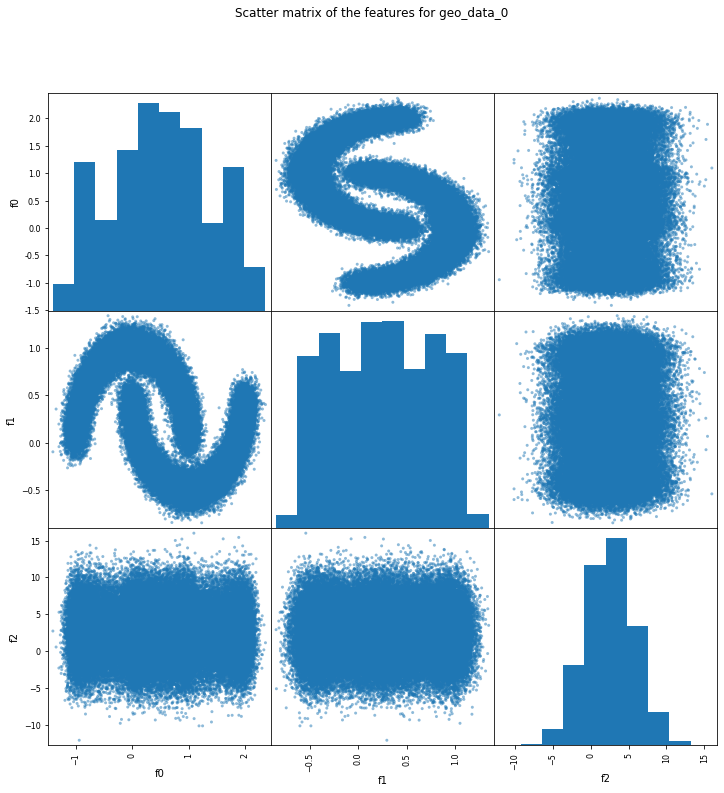

In [7]:
def create_features_target_scatter_matrix(df, df_name):
    """
    создает features и target для датасета df и строит корреляционную матрицу
    """
    features = df.drop(['product','id'], axis=1)
    target = df['product']
    title_name = "Scatter matrix of the features for " + df_name

    pd.plotting.scatter_matrix(features, figsize=(12, 12)) 
    plt.suptitle(title_name)
    plt.show()
    return features, target

features_0, target_0 = create_features_target_scatter_matrix(geo_data_0, 'geo_data_0')

Есть подозрительная связь f0 и f1 в geo_data_0. Нет предположений, с чем это может быть связано (кроме того, что данные синтетические), и как это учитывать. Об этом стоит поговорить с компанией. Проверим коэффициент корреляции для этих признаков.

In [8]:
print('Корреляция f0 и f1 в geo_data_0:', geo_data_0['f0'].corr(geo_data_0['f1']))

Корреляция f0 и f1 в geo_data_0: -0.44072285097195446


Коэффициент корреляции не мал, но и не настолько большой, чтобы избавляться от одного из признаков. Продолжим проверку на мультиколлинеарность признаков.

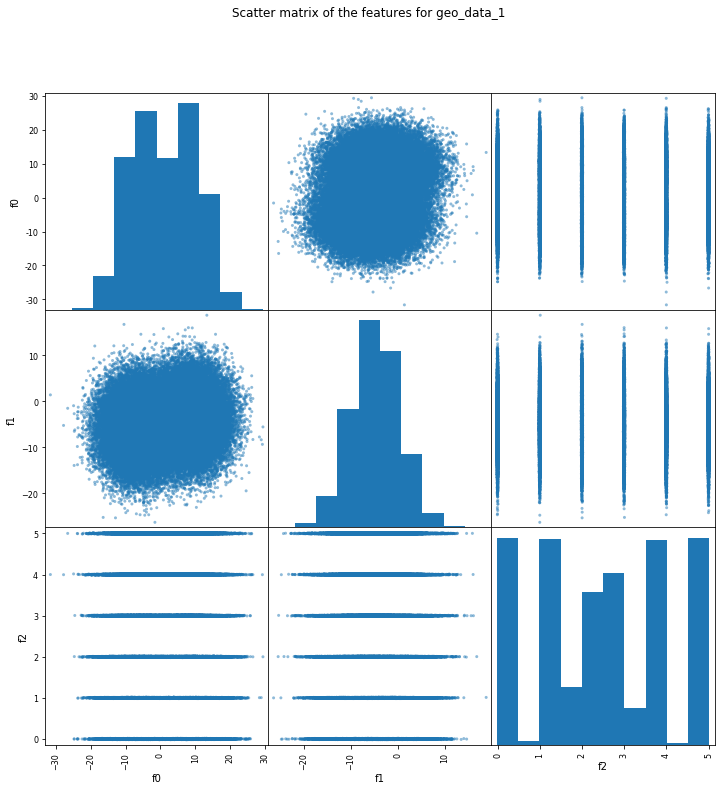

In [9]:
features_1, target_1 = create_features_target_scatter_matrix(geo_data_1, 'geo_data_1')

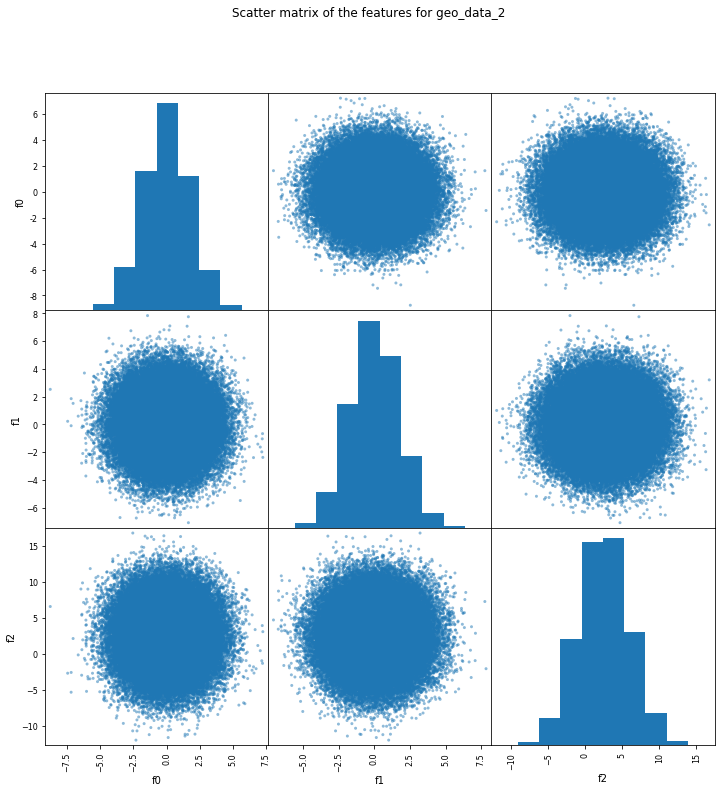

In [10]:
features_2, target_2 = create_features_target_scatter_matrix(geo_data_2, 'geo_data_2')

### Вывод

- Дубликатов и пропусков нет


- В большинстве распределение нормальное, кроме f0 и f1 для geo_data_0 (есть тяжёлые хвосты), и f2 и product для geo_data_1, распределение которых близко к равномерному.


- Подозрительных выбросов не видно.


- Есть подозрительная связь f0 и f1 в geo_data_0. Об этом стоит поговорить с компанией. 


- Коэффициент корреляции f2 и product для geo_data_1 равен почти 1. Этот признак существенно повлияет на выбор скважин в данном регионе.

## Обучение и проверка модели

Разделим выборки на обучающую и валидационную.

In [11]:
def split_samples(features, target, df_name):
    """
    Разделяет features и target в одном датасете и выводит размеры обучающих и валидационных фич
    """
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=12)

    print(df_name)
    print('Размер обучающих фич:', features_train.shape)
    print('Размер валидационных фич:', features_valid.shape)
    return features_train, features_valid, target_train, target_valid

In [12]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = split_samples(features_0, target_0, 'geo_data_0')

geo_data_0
Размер обучающих фич: (75000, 3)
Размер валидационных фич: (25000, 3)


In [13]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = split_samples(features_1, target_1, 'geo_data_1')

geo_data_1
Размер обучающих фич: (75000, 3)
Размер валидационных фич: (25000, 3)


In [14]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = split_samples(features_2, target_2, 'geo_data_2')

geo_data_2
Размер обучающих фич: (75000, 3)
Размер валидационных фич: (25000, 3)


Масштабируем признаки.

In [15]:
def scalar_each_dataset(features_train, features_valid):

    scaler = StandardScaler()
    scaler.fit(features_train)

    features_train = scaler.transform(features_train)
    features_valid = scaler.transform(features_valid)
    
    return features_train, features_valid

features_train_0, features_valid_0 = scalar_each_dataset(features_train_0, features_valid_0)

In [16]:
features_train_1, features_valid_1 = scalar_each_dataset(features_train_1, features_valid_1)

In [17]:
features_train_2, features_valid_2 = scalar_each_dataset(features_train_2, features_valid_2)

Обучим модель.

In [18]:
def train_model_get_predictions(features_train, features_valid, target_train, target_valid, df_name):
    """
    Строит модель для одного региона, считает предсказания, выводит RMSE и средний запас предсказанного сырья
    """
    model = LinearRegression()
    model.fit(features_train, target_train) 
    predictions_valid = pd.Series(model.predict(features_valid), index=target_valid.index)
    rmse = mean_squared_error(target_valid, predictions_valid) ** 0.5
    print('Регион', df_name)
    print("RMSE модели на валидационной выборке:", rmse)
    print("Средний запас предсказанного сырья:", predictions_valid.mean().round(decimals=2), 'тыс. баррелей')
    print()
    return model, predictions_valid, rmse

In [19]:
model_0, predictions_valid_0, rmse_0 = \
    train_model_get_predictions(features_train_0, features_valid_0, target_train_0, target_valid_0, 'geo_data_0')

model_1, predictions_valid_1, rmse_1 = \
    train_model_get_predictions(features_train_1, features_valid_1, target_train_1, target_valid_1, 'geo_data_1')

model_2, predictions_valid_2, rmse_2 = \
    train_model_get_predictions(features_train_2, features_valid_2, target_train_2, target_valid_2, 'geo_data_2')

Регион geo_data_0
RMSE модели на валидационной выборке: 37.78806596603057
Средний запас предсказанного сырья: 92.13 тыс. баррелей

Регион geo_data_1
RMSE модели на валидационной выборке: 0.8885339556138773
Средний запас предсказанного сырья: 69.04 тыс. баррелей

Регион geo_data_2
RMSE модели на валидационной выборке: 39.800203117903365
Средний запас предсказанного сырья: 95.05 тыс. баррелей



### Вывод

Средний запас предсказанного сырья для регионов geo_data_0 и geo_data_2 почти совпадает (92.13 и 95.05 тыс. баррелей) и прилично выше, чем для geo_data_1 (69.04 тыс. баррелей). Однако RMSE модели для geo_data_1 существенно ниже (0.89), чем для остальных регионов (37.79 и 39.80), что показывает, что в регионе geo_data_1 прогноз точнее, а высокое значение среднего запаса предсказанного сырья для регионов geo_data_0 и geo_data_2 могло получиться за счёт больших ошибок.

## Подготовка к расчёту прибыли

Создадим константы, данные компанией:

In [20]:
NUMBER_OF_POINTS_FOR_INVESTIGATION = 500
NUMBER_OF_BEST_BOREHOLES = 200
BUDGET = 10e9 # тысяч рублей. Бюджет на разработку скважин в регионе
PRICE_FOR_1_UNIT = 450000 # тысяч рублей за единицу продукта, указанную в тысячах баррелей
MAX_PROB_OF_LOST = 2.5 

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.

In [21]:
BUDGET_FOR_ONE_BOREHOLE = BUDGET / NUMBER_OF_BEST_BOREHOLES # средний бюджет на разработку одной скважины
LOSS_FREE_VOLUME = BUDGET_FOR_ONE_BOREHOLE / PRICE_FOR_1_UNIT # достаточный объём сырья для безубыточной разработки новой скважины
print('Достаточный объём сырья для безубыточной разработки новой скважины', np.ceil(LOSS_FREE_VOLUME), 'тыс. баррелей')

Достаточный объём сырья для безубыточной разработки новой скважины 112.0 тыс. баррелей


Напишем функцию подсчёта прибыли:

In [22]:
def true_revenue(predictions, target):
    """
    Сортирует по убыванию предсказания (predictions) модели, 
    отбирает из истинных значений (target) заданное количество (NUMBER_OF_BEST_BOREHOLES) лучших (согласно прогнозу),
    считает истинную прибыль
    """
    predictions_sorted = predictions.sort_values(ascending=False)
    selected = target.loc[predictions_sorted.index][:NUMBER_OF_BEST_BOREHOLES]
    return PRICE_FOR_1_UNIT * selected.sum() - BUDGET

### Вывод

Минимальное среднее количество продукта в месторождениях региона, достаточное для разработки, составляет 112 тыс. баррелей, что выше среднего запаса предсказанного сырья в скважине, поэтому отбор скважин имеет большое значение, иначе легко получить убыток.

## Расчёт прибыли и рисков 

Проведём процедуру Bootstrap.

In [27]:
def true_revenue_distribution(predictions, target, region_name):
    """
    Считает распределение истинной прибыли, среднюю прибыль по региону и доверительный интервал
    """
    state = np.random.RandomState(12)
    revenues = []
    
    for i in range(1000):
        target_subsample = target.sample(replace=True, n=NUMBER_OF_POINTS_FOR_INVESTIGATION, random_state=state)
        predictions_subsample = predictions.loc[target_subsample.index] 
        revenues.append(true_revenue(predictions_subsample, target_subsample))
        
    revenues = pd.Series(revenues)
    revenue_mean = revenues.mean().round()
    revenue_lower = revenues.quantile(0.025).round()
    revenue_upper = revenues.quantile(0.975).round()
    print(region_name)
    print('Средняя прибыль:', revenue_mean, 'руб')
    print('Доверительный интервал:', revenue_lower, ':', revenue_upper)
    print('----------------------------------')
    return revenues, revenue_mean, revenue_lower, revenue_upper

true_revenue_distribution_0, revenue_mean_0, revenue_lower_0, revenue_upper_0 = \
    true_revenue_distribution(predictions_valid_0, target_valid_0, 'geo_data_0')

true_revenue_distribution_1, revenue_mean_1, revenue_lower_1, revenue_upper_1 = \
    true_revenue_distribution(predictions_valid_1, target_valid_1, 'geo_data_1')

true_revenue_distribution_2, revenue_mean_2, revenue_lower_2, revenue_upper_2 = \
    true_revenue_distribution(predictions_valid_2, target_valid_2, 'geo_data_2')

geo_data_0
Средняя прибыль: 475541876.0 руб
Доверительный интервал: -50083021.0 : 1008353696.0
----------------------------------
geo_data_1
Средняя прибыль: 559209625.0 руб
Доверительный интервал: 123128585.0 : 998014333.0
----------------------------------
geo_data_2
Средняя прибыль: 360364122.0 руб
Доверительный интервал: -203951029.0 : 911717589.0
----------------------------------


Посчитаем вероятность убытков для каждого региона:

In [24]:
def region_prob_loss(true_revenue_distribution, region_name):
    prob_of_loss = len(true_revenue_distribution[true_revenue_distribution < 0]) / len(true_revenue_distribution)
    print("Вероятность убытков для {}: {:.2%}".format(region_name, prob_of_loss))
    return prob_of_loss

prob_of_loss_0 = region_prob_loss(true_revenue_distribution_0, 'geo_data_0')
prob_of_loss_1 = region_prob_loss(true_revenue_distribution_1, 'geo_data_1')
prob_of_loss_2 = region_prob_loss(true_revenue_distribution_2, 'geo_data_2')

Вероятность убытков для geo_data_0: 3.90%
Вероятность убытков для geo_data_1: 0.50%
Вероятность убытков для geo_data_2: 9.80%


In [25]:
data_finish = {'Средняя прибыль, млн. руб.' : \
               [round(revenue_mean_0 / 10e6, 2), round(revenue_mean_1 / 10e6, 2), round(revenue_mean_2 / 10e6, 2)],
               'Нижняя граница, млн. руб.' : \
               [round(revenue_lower_0 / 10e6, 2), round(revenue_lower_1 / 10e6, 2), round(revenue_lower_2 / 10e6, 2)],
               'Верхняя граница, млн. руб.' : \
               [round(revenue_upper_0 / 10e6, 2), round(revenue_upper_1 / 10e6, 2), round(revenue_upper_2 / 10e6, 2)],
              'Вероятность убытков, %' : \
               [prob_of_loss_0 * 100, prob_of_loss_1 * 100, prob_of_loss_2 * 100]}
frame = pd.DataFrame(data_finish, index = ['geo_data_0', 'geo_data_1', 'geo_data_2'])

In [26]:
display(frame)

,"Средняя прибыль, млн. руб.","Нижняя граница, млн. руб.","Верхняя граница, млн. руб.","Вероятность убытков, %"
geo_data_0,47.55,-5.01,100.84,3.9
geo_data_1,55.92,12.31,99.80,0.5
geo_data_2,36.04,-20.40,91.17,9.8


### Вывод

Наибольшая средняя прибыль (почти 56 млн руб) и наименьшая вероятность убытков (0.5%) - в регионе geo_data_1.
Регион geo_data_2 показал самые неблагоприятные результаты: средняя прибыль 36 млн руб, а вероятность убытков - почти 10%, причём размер убытков может оказаться огромным (20 млн). Сводка результатов по всем регионам:

In [27]:
display(frame)

,"Средняя прибыль, млн. руб.","Нижняя граница, млн. руб.","Верхняя граница, млн. руб.","Вероятность убытков, %"
geo_data_0,47.55,-5.01,100.84,3.9
geo_data_1,55.92,12.31,99.80,0.5
geo_data_2,36.04,-20.40,91.17,9.8


## Общий вывод

Мы построили модель для задачи регрессии, которая оценивают объём запасов нефти в регионе по предоставленым пробам и рассчитывает возможную среднюю прибыль. 

Для этого мы:

- Проверили адекватность данных а также корреляционную связь между признаками. Есть подозрительная связь f0 и f1 в geo_data_0. Стоит это обсудить с заказчиком. В остальном данные готовы для дальнейшей работы.


- Разбили имеющиеся у нас выборки на обучающие и валидационные. Обучили модель линейной регрессии на обучающих выборках.


- Посчитали RMSE моделей для разных регионов. Наилучшее значение (0.89) - для региона geo_data_1.


- Рассчитали для каждого региона средний запас предсказанного сырья и достаточный объём сырья для безубыточной разработки новой скважины (112.0 тыс. баррелей). Средний запас в каждом регионе оказался существенно ниже 112 тыс баррелей. Таким образом **без выбора скважин не обойтись, иначе разработка приведет скорее к убыткам**.


- Провели процедуру Bootstrap, с помощью которой для каждого региона отобрали наилучшие скважины, посчитали среднюю прибыль, доверительный интервал и вероятность убытков. Так, риск получить убыток получился ниже 2.5% только для региона geo_data_1.


- Регион geo_data_2 показал самые неблагоприятные результаты: средняя прибыль 36 млн руб, а вероятность убытков - почти 10%, причём размер убытков может оказаться огромным (20 млн).


**Лучший результат показал регион geo_data_1: предсказаная средняя прибыль составляет почти 56 млн руб, а вероятность убытков 0.5%.**

Сводка результатов по всем регионам:

In [28]:
display(frame)

,"Средняя прибыль, млн. руб.","Нижняя граница, млн. руб.","Верхняя граница, млн. руб.","Вероятность убытков, %"
geo_data_0,47.55,-5.01,100.84,3.9
geo_data_1,55.92,12.31,99.80,0.5
geo_data_2,36.04,-20.40,91.17,9.8
